In [1]:
import os
import gc
import cv2
import glob
import json
import torch
import random

import numpy as np
import torch.nn as nn
import albumentations as A
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
from albumentations.pytorch.transforms import ToTensorV2

In [2]:
dir_name = 'training_sample'
if os.path.exists(dir_name) == False :
    os.mkdir(dir_name)

subdir_li = ['models', 'metrics']
for sn in subdir_li:
    subdir_path = f'{dir_name}/{sn}'
    
    if os.path.exists(subdir_path) == False :
        os.mkdir(subdir_path)
        
def load_model_info(json_path, model_name):
    with open(json_path, 'r') as f:
        model_info = json.load(f)
    return model_info[model_name]

seed = 42
json_path = 'model_information.json'
fm_name = 'ctranspath'
fm_info = load_model_info(json_path, fm_name)

fm_mean = fm_info['mean']
fm_std = fm_info['std']
fm_ps = fm_info['patch_size']
fm_fd = fm_info['feature_dim']

In [3]:
data_path = "_"
ln_li = list(np.sort(glob.glob(data_path+'/LN*/*.png')))
noln_li = list(np.sort(glob.glob(data_path+'/NOLN*/*.png')))

tr_ln, vd_ln = train_test_split(ln_li, test_size=0.2, random_state=seed)
tr_noln, vd_noln = train_test_split(noln_li, test_size=0.2, random_state=seed)

print(f"Training LN data: {len(tr_ln)}")
print(f"Validation LN data: {len(vd_ln)}")
print(f"Training NOLN data: {len(tr_noln)}")
print(f"Validation NOLN data: {len(vd_noln)}")

Training LN data: 28187
Validation LN data: 7047
Training NOLN data: 19890
Validation NOLN data: 4973


In [4]:
class CustomDataset(Dataset):
    def __init__(self, patch_li, transforms, normalize):
        self.patch_li = patch_li
        self.transforms = transforms
        self.normalize = normalize
        
    def __getitem__(self, idx):
        img = cv2.imread(self.patch_li[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        tr = self.transforms(image=img)
        img = tr['image']
        nm = self.normalize(image=img)
        img = nm['image']

        if '/NOLN_' in self.patch_li[idx]:
            label = torch.Tensor([[1.,0.]])
        else:
            label = torch.Tensor([[0.,1.]])
        
        return img, label
    
    def __len__(self):
        return len(self.patch_li)

In [5]:
def tr_transforms(patch_size):
    _transform = [
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Affine(scale=(0.9, 1.2), rotate=(-10,10), shear=30),
        A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3, p=1),
        A.GaussianBlur(3,sigma_limit=(0.1,1.5)),
        
        A.RandomCrop(patch_size*2, patch_size*2),
        A.Resize(patch_size,patch_size),
    ]
    return A.Compose(_transform)

def vd_transforms(patch_size):
    _transform = [
        A.RandomCrop(patch_size*2, patch_size*2),
        A.Resize(patch_size,patch_size),
    ]
    return A.Compose(_transform)

def fm_norm(mean, std):
    _transform = [
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
    return A.Compose(_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


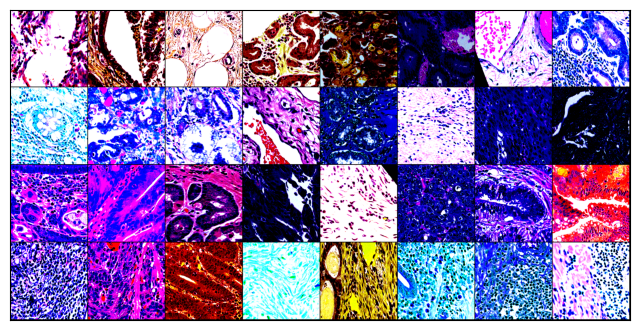

In [6]:
bs=16
tst_ln_dst = CustomDataset(tr_ln, tr_transforms(fm_ps), fm_norm(fm_mean, fm_std))
tst_ln_ld = DataLoader(tst_ln_dst, batch_size=bs)
tst_noln_dst = CustomDataset(tr_noln, tr_transforms(fm_ps), fm_norm(fm_mean, fm_std))
tst_noln_ld = DataLoader(tst_noln_dst, batch_size=bs)

for (ln_patches, _), (noln_patches, _) in zip(tst_ln_ld, tst_noln_ld):
    patches = torch.cat((ln_patches, noln_patches), axis=0)
    
    fig, img = plt.subplots(figsize = (8, 8))
    img.set_xticks([])
    img.set_yticks([])
    img.imshow(make_grid(patches,8).permute(1, 2, 0))
    plt.show()
   
    break

del tst_ln_dst, tst_ln_ld
del tst_noln_dst, tst_noln_ld

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


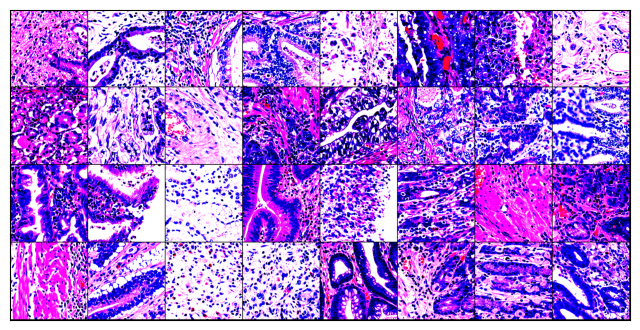

In [7]:
bs=16
tst_ln_dst = CustomDataset(vd_ln, vd_transforms(fm_ps), fm_norm(fm_mean, fm_std))
tst_ln_ld = DataLoader(tst_ln_dst, batch_size=bs)
tst_noln_dst = CustomDataset(vd_noln, vd_transforms(fm_ps), fm_norm(fm_mean, fm_std))
tst_noln_ld = DataLoader(tst_noln_dst, batch_size=bs)

for (ln_patches, _), (noln_patches, _) in zip(tst_ln_ld, tst_noln_ld):
    patches = torch.cat((ln_patches, noln_patches), axis=0)
    
    fig, img = plt.subplots(figsize = (8, 8))
    img.set_xticks([])
    img.set_yticks([])
    img.imshow(make_grid(patches,8).permute(1, 2, 0))
    plt.show()
   
    break

del tst_ln_dst, tst_ln_ld
del tst_noln_dst, tst_noln_ld

In [8]:
# The feature_extractor is implemented with reference to model_usage_example.ipynb.

In [9]:
for param in feature_extractor.parameters():
    param.requires_grad = False 

In [10]:
classifier = nn.Sequential(
    nn.Linear(fm_fd,int(fm_fd*.75)),
    nn.ReLU(),
    nn.Linear(int(fm_fd*.75),int(fm_fd*.5)),
    nn.ReLU(),
    nn.Linear(int(fm_fd*.5),2)
)

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
feature_extractor.to(device)
classifier.to(device)

max_epochs = 2
valid_interval = 1
lr = 1e-4
wd = 1e-3
best_loss = 1000.

optimizer = torch.optim.AdamW(classifier.parameters(), lr=lr,weight_decay=wd)
criterion = nn.CrossEntropyLoss()

In [12]:
bs=128
tr_ln_dst = CustomDataset(tr_ln, tr_transforms(fm_ps), fm_norm(fm_mean, fm_std))
tr_ln_ld = DataLoader(tr_ln_dst, batch_size=bs, shuffle=True)
tr_noln_dst = CustomDataset(tr_noln, tr_transforms(fm_ps), fm_norm(fm_mean, fm_std))
tr_noln_ld = DataLoader(tr_noln_dst, batch_size=bs, shuffle=True)

vd_ln_dst = CustomDataset(vd_ln, vd_transforms(fm_ps), fm_norm(fm_mean, fm_std))
vd_ln_ld = DataLoader(vd_ln_dst, batch_size=bs)
vd_noln_dst = CustomDataset(vd_noln, vd_transforms(fm_ps), fm_norm(fm_mean, fm_std))
vd_noln_ld = DataLoader(vd_noln_dst, batch_size=bs)

In [13]:
tr_loss_li, tr_mloss_li = [], []
vd_loss_li, vd_mloss_li = [], []

In [14]:
for epoch in range(max_epochs):
    step = 0
    for (ln_patches, ln_labels), (noln_patches, noln_labels) in zip(tr_ln_ld, tr_noln_ld):
        if len(ln_patches) !=bs:
            break
            
        step += 1
        
        tr_patches = torch.zeros([bs*2, 3, fm_ps, fm_ps])
        tr_labels = torch.zeros([bs*2, 1, 2])
        
        tr_patches[:bs, :, :, :] = ln_patches
        tr_patches[bs:, :, :, :] = noln_patches
        tr_labels[:bs, :, :] = ln_labels
        tr_labels[bs:, :, :] = noln_labels

        tr_patches = tr_patches.to(device)
        tr_labels = tr_labels.to(device)
        
        feature_extractor.eval()
        with torch.no_grad():
            extracted_features = feature_extractor(tr_patches)[:,0]
            
        classifier.train()
        outputs = classifier(extracted_features)
        probs = outputs.softmax(1)
        
        indices = torch.argmax(tr_labels[:,0,:].long(), dim=1)
        tr_loss = criterion(probs, indices)
        
        optimizer.zero_grad()
        tr_loss.backward()
        optimizer.step()
        
        tr_loss_li.append(tr_loss.item())
        
        if step%valid_interval ==0:
            for ln_patches, ln_labels in vd_ln_ld:
                ln_patches = ln_patches.to(device)
                ln_labels = ln_labels.to(device)
                feature_extractor.eval()
                with torch.no_grad():
                    extracted_features = feature_extractor(ln_patches)[:,0]
                    
                classifier.eval()
                outputs = classifier(extracted_features)
                probs = outputs.softmax(1)
                indices = torch.argmax(ln_labels[:,0,:].long(), dim=1)
                vd_loss = criterion(probs, indices)
                vd_loss_li.append(vd_loss.item())
                
            for noln_patches, noln_labels in vd_noln_ld:
                noln_patches = noln_patches.to(device)
                noln_labels = noln_labels.to(device)
                feature_extractor.eval()
                with torch.no_grad():
                    extracted_features = feature_extractor(noln_patches)[:,0]
                    
                classifier.eval()
                outputs = classifier(extracted_features)
                probs = outputs.softmax(1)
                indices = torch.argmax(noln_labels[:,0,:].long(), dim=1)
                vd_loss = criterion(probs, indices)
                vd_loss_li.append(vd_loss.item())
            
            tr_mloss_li.append(np.array(tr_loss_li).mean())
            vd_mloss_li.append(np.array(vd_loss_li).mean())
            
            tr_loss_li, vd_loss_li = [], []
            checkpoint = {'state_dict': classifier.state_dict()}
            torch.save(checkpoint, os.path.join(dir_name, 'models', f'last_model.pt'))
            
            current_loss = vd_mloss_li[-1]
            if current_loss < best_loss :
                best_loss = current_loss
                torch.save(checkpoint, os.path.join(dir_name, 'models', f'best_model.pt'))
            
            plt.figure(figsize=(16,24))
            plt.subplot(1,2,1)
            plt.plot(list(range(len(tr_mloss_li))), tr_mloss_li)
            plt.title(f'Train Loss')

            plt.subplot(1,2,2)
            plt.plot(list(range(len(vd_mloss_li))), vd_mloss_li)
            plt.title(f'Valid Loss')

            plt.savefig(os.path.join(dir_name, 'metrics', f'loss.png'))
            
            gc.collect()
            torch.cuda.empty_cache()
            
torch.save({
    'classifier': model.state_dict(),
    'optimizer': optimizer.state_dict()
},os.path.join(dir_path, 'models', f'model_and_optim.pt') )